In [1]:
import pandas as pd 
import numpy as np
import openai
import os
import langchain
import faiss # defunct needs to be removed
from langchain.vectorstores import FAISS # defunct needs to be removed
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
import pickle
from langchain.chat_models import ChatOpenAI
#from langchain.chains import VectorDBQAWithSourcesChain
from langchain.chains import RetrievalQAWithSourcesChain
from langchain import OpenAI
from langchain.vectorstores import Chroma
import time

import matplotlib

import dotenv
from dotenv import load_dotenv
load_dotenv()
# load the .env file
dotenv.load_dotenv()
# add the api key to the environment
openai.api_key = os.environ["OPENAI_API_KEY"]


In [ ]:
#read in all the links for each school 
charter_content=pd.read_csv('processed_data/charter_contents.csv')

In [ ]:
charter_content.head(10) # would the header be a problem for the model and also the footer that messed up the embeds?

In [28]:
charter_links=pd.read_csv('processed_data/charter_links.csv')

In [ ]:
charter_content.shape

In [ ]:
charter_links.shape

In [ ]:
charter_school_merge_content=charter_content.merge(charter_links)

In [ ]:
charter_school_merge_content

In [ ]:
#charter_school_merge_content.to_csv('processed_data/charter_school_merge_content.csv',index=False)

In [ ]:
charter_school_merge_content.schoolname.nunique()

In [19]:
merge_charter=pd.read_csv('processed_data/merge_charter_district.csv')

In [20]:
merge_charter

,countydescription,political_afil,extract_name_clean_list,schoolname,principal/directoremail,website,board_of_directors_link,link_domain_match,director_first_last,cleaner_names,...,postal_code,latitude,longitude,count_dem,count_rep,count_una,district_count_dem,district_count_rep,district_count_una,school_homepage
0,Durham,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM', 'DEM']","['Bettina Umstead', ' Emily Chavez', ' Natalie...",North Carolina Cyber Academy,mhill@myncca.com,myncca.com,https://www.myncca.com/our-school-board,True,"[('Jill', 'Hammergren'), ('Audrey', 'Martin'),...","['Julie Marks', 'Jill Hammergren', 'Debora Wil...",...,27713,35.9112,-78.9178,5,2,0,6,0,1,https://www.myncca.com/
1,Durham,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM', 'DEM']","['Bettina Umstead', ' Emily Chavez', ' Natalie...",NC Virtual Academy,kgomersall@ncvacademy.org,ncvacademy.org,https://ncva.k12.com/about-our-school/board-of...,False,"[('Sara', 'W'), ('C.', 'Struhs'), ('Sara', 'St...","['Steven Peters', 'Sara Struhs', 'Mark Fleming...",...,27713,35.9112,-78.9178,2,2,2,6,0,1,https://ncva.k12.com/%3Futm_source%3Dgoogle%26...
2,Durham,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM', 'DEM']","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Maureen Joy Charter School,Dcannon@joycharter.org,joycharter.org,https://www.joycharter.org/board,True,"[('Elan', 'Hope'), ('Helen', 'Bryant'), ('Regi...","['Elan Hope', 'Helen Bryant', 'Reginald J. Joh...",...,27703,35.9781,-78.8439,6,1,2,6,0,1,http://www.joycharter.org/
3,Durham,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM', 'DEM']","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Durham Charter School,aquigley@durhamcharter.org,durhamcharter.org,https://www.durhamcharter.org/board-of-directors/,True,"[('Matt', 'Les'), ('Preston', 'Michael'), ('Ca...","['Gerald Mc Nair', 'Elizabeth Gnatek Morey Ch...",...,27701,35.9967,-78.8966,2,4,4,6,0,1,https://www.durhamcharter.org/
4,Durham,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM', 'DEM']","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Community School of Digital & Visual Art,OAdeniyi@communitydva.org,communitydva.org,https://www.communitydva.org/,True,[],"['Brian Crawford', 'Joe Battle', 'Michael Palm...",...,27705,36.0218,-78.9478,5,0,1,6,0,1,https://www.communitydva.org/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Watauga,"['UNA', 'UNA', 'DEM', 'DEM', 'REP', 'UNA', 'RE...","['Gary L. Childers', ' John Fenwick', ' John A...",Two Rivers Community School,natalie@trcsboone.org,trcsboone.org,https://www.trgators.org/o/two-rivers-school-d...,False,"[('Stele', 'James'), ('Doug', 'Morell'), ('Rya...","['Melissa Thomas', 'Carole Greene', 'Twila Win...",...,28607,36.2142,-81.6660,2,0,3,6,6,5,http://www.tworiverscommunityschool.net/
202,Wayne,"['REP', 'REP', 'DEM', 'DEM', 'UNA', 'REP']","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Dillard Academy,cbattle@dillardacademy.org,dillardacademy.org,http://www.dillardacademy.org/board-of-directo...,True,"[('Janet', 'Ward'), ('Thomas', 'Smith'), ('Mar...","['Janet Ward', 'Christina Robles', 'Mary James...",...,27530,35.3683,-78.0929,3,3,1,2,3,1,http://www.dillardacademy.org/
203,Wayne,"['REP', 'REP', 'DEM', 'DEM', 'UNA', 'REP']","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Wayne Preparatory Academy,jtwitty@wpanc.org,wpanc.org,https://wpanc.net/our-board/,False,"[('Amanda', 'Wells'), ('Scott', 'Mack'), ('Cha...","['Charles Gaylor', 'Scott Mackey', 'Amanda Wel...",...,27530,35.3683,-78.0929,1,1,1,2,3,1,https://wpanc.net/
204,Wilson,"['DEM', 'DEM', 'DEM', 'UNA', 'DEM', 'UNA', 'REP']","['Debora Powell', ' Velma Barnes', ' Christine...",Sallie B Howard School,"jwoodard@sallieb.net, sandeep@sallieb.net",sallieb.net,https://salliebhowardschool.com/meet-our-staff...,False,"[('JoAnne', 'Woodard'), ('JoAnne', 'Woodard')]",['JoAnne Woodard'],...,27893,35.7270,-77.9227,0,1,0,4,1,2,http://www.salliebhowardschool.com/


In [29]:
content_school_list=list(charter_school_merge_content.schoolname.unique())
original_school_list=list(merge_charter.schoolname.unique())

In [32]:
#missing 46 schools
missing_school_name_dict=set(content_school_list).symmetric_difference(set(original_school_list))

In [35]:
pd.DataFrame(data=missing_school_name_dict).to_csv('missing_school_names.csv',index=False) 

In [ ]:
#todo crawl this list - of 40 schools that are not in the content list
merge_charter.loc[merge_charter.schoolname=='Sallie B Howard School']

In [6]:
charter_school_merge_content = pd.read_csv('processed_data/charter_school_merge_content.csv')

In [3]:
charter_school_merge_content.content=charter_school_merge_content.content.astype(str)# test out 3 schools

In [40]:
# Assume df is your DataFrame and it has columns 'content', 'url', and 'schoolname'
df = charter_school_merge_content
docs, metadatas = [], [],
text_splitter = CharacterTextSplitter(chunk_size=200,chunk_overlap=0, separator="\n")
for idx, row in df.iterrows():
    splits = text_splitter.split_text(row['content'])
    docs.extend(splits)
    metadatas.extend([{"source": row['url'], "schoolname": row['schoolname']}] * len(splits))
texts=text_splitter.create_documents(docs,metadatas=metadatas)

## start new chroma vector database from documents

In [43]:
# embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", chunk_size=1, max_retries=10)
# persist_directory = "./chromadb"
# # Initialize the vector db with the first document
# vectordb = Chroma.from_documents(texts, embeddings, persist_directory=persist_directory)
# vectordb.persist()

## load existing chroma vector database

In [2]:
#example on how to load the chromadb persisted vector store
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", chunk_size=1, max_retries=10)
persist_directory = "./chromadb"
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

In [3]:
list(charter_school_merge_content[charter_school_merge_content['schoolname'] == "Union Prep Academy at Indian Trail"].url)

NameError: name 'charter_school_merge_content' is not defined

In [123]:
list(charter_school_merge_content[charter_school_merge_content.url == 'https://www.dillardacademy.org/visionmission.html'].content)

['Menu High Expectations in Academics, Behavior Character Dillard Academy will prepare all students to succeed in global society by providing diverse, collaborative, and technological, academic climate empowering 80% of students to be proficient by 2023. To positively provide safe and quality education with high expectations so that we can excel and grow! R, N." At Dillard Academy, we know that all children have potential. Our students will achieve their goals and succeed in school and in life, because they are taught to believe in themselves. Dillard Academy Charter School S) has been open since 1998. We are non-profit, public charter school. Tuition, transportation and meals are free at Dillard Academy. Our teachers are Certified and Highly Qualified. 919-581-0128 919-736-3103 504 W. Elm Street, P. O. Box 1188, Goldsboro, 27530 E. This institution is an equal opportunity provider. Home D-19 Updates Administration Founder/ Executive Director Board of Directors Principal Assistant Prin

In [73]:
charter_school_merge_content.schoolname.sample()

3668    Unity Classical Charter School
Name: schoolname, dtype: object

In [72]:
# example of similiarty search on mission statement per filter criteria
#filter_crit = {'schoolname': 'Phoenix Academy - Primary, Elem, Upper'}
#vectordb.similarity_search('mission statement', filter=filter_crit)

In [14]:
## sample example of qa doc retriveal
def sample_vector_mission_find(schoolname:str):
    filter_crit = {'schoolname': f"{schoolname}"} # does filter criterial for metadata matter? 
    retriever=vectordb.as_retriever(search_type="similarity",search_kwargs={'k':3,'filter':filter_crit},)
    llm = ChatOpenAI(temperature=0,model='gpt-3.5-turbo-16k')
    chain = RetrievalQAWithSourcesChain.from_chain_type(
                llm=llm,chain_type="stuff",retriever=retriever,reduce_k_below_max_tokens=True)
    # what is the vision/mission of the school for students in the about us?
    result = chain({"question": 'what is mission of the school?',},return_only_outputs=True)
    print(f"{result['answer']}")
    print(f"Sources: {result['sources']}")

In [10]:
## sample example of qa doc retriveal
def vector_mission_find(schoolname:str):
    filter_crit = {'schoolname': f"{schoolname}"} # does filter criterial for metadata matter? 
    retriever=vectordb.as_retriever(search_type="similarity",search_kwargs={'k':1,'filter':filter_crit},)
    llm = ChatOpenAI(temperature=0,model='gpt-3.5-turbo-16k')
    chain = RetrievalQAWithSourcesChain.from_chain_type(
                llm=llm,chain_type="stuff",retriever=retriever,reduce_k_below_max_tokens=True)
    result = chain({"question": 'what is mission of the school?',})
    return result['answer']
# what is the vision/mission of the school for students in the about us?
# 'what is the mission statement of the school for students?'
# 'what is mission of the school?'

In [91]:
#names are captured from charter_school_merge_content
unique_school_names = charter_school_merge_content.schoolname.unique()
charter_vector_mission = pd.DataFrame(unique_school_names, columns=['schoolname'])

In [208]:
charter_vector_mission
charter_vector_mission[charter_vector_mission['schoolname'].str.contains("'")]
#charter_vector_mission['schoolname'] = charter_vector_mission['schoolname'].str.replace("'","''") # revert this back to original for merging
# dropping waters edge village and childern village because of apostraphes messing up the double single quotes in the database

,schoolname,mission_statement
36,Water''s Edge Village School,The document does not provide information abou...
74,Children''s Village Academy,The vision/mission of the school for students ...


In [40]:
sample_vector_mission_find("River Mill Academy")

The mission of the school is to support a partnership between school and home, providing information, meetings, workshops, and conferences to assist parents in improving their children's achievement. The school aims to involve parents in the planning, review, and evaluation of programs and to communicate clearly and frequently with parents about school policies and programs. The school also educates school personnel on the value of parental contributions and how to build ties between parents and the school.

Sources: https://www.rivermill-academy.org/about_r_m_a/parent_involvement_plan


In [209]:
charter_vector_mission['mission_statement_shorten']=charter_vector_mission.apply(lambda x: vector_mission_find(x['schoolname']), axis=1)

In [211]:

#charter_vector_mission['schoolname'] = charter_vector_mission['schoolname'].str.replace("''","'")
charter_vector_mission[charter_vector_mission['schoolname'].str.contains("'")]

,schoolname,mission_statement,mission_statement_shorten
36,Water's Edge Village School,The document does not provide information abou...,The mission statement of Water's Edge Village ...
74,Children's Village Academy,The vision/mission of the school for students ...,The mission statement of the school for studen...


In [214]:
charter_vector_mission


0      The mission statement of the school for studen...
1      The mission statement of the school for studen...
2      The mission statement of the school for studen...
3      The mission statement of Durham Charter School...
4      The mission statement of the school for studen...
                             ...                        
155    The mission statement of the school for studen...
156    I don't know the mission statement of the scho...
157    The mission statement of the school for studen...
158    The mission statement of the school for studen...
159    The mission statement of the school for studen...
Name: mission_statement_shorten, Length: 160, dtype: object

In [215]:
charter_vector_mission.to_csv('processed_data/charter_vector_mission_revised.csv',index=False)

## Faiss Vector store db

In [ ]:
## FAISS vector store 
## embed the docs
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
store = FAISS.from_texts(docs, OpenAIEmbeddings(), metadatas=metadatas)
with open("faiss_store.pkl", "wb") as f:
    pickle.dump(store, f)

In [ ]:
with open("faiss_store.pkl", "rb") as f:
    store = pickle.load(f)

In [ ]:
## sample example of qa doc retriveal
filter_crit = {'schoolname': 'Maureen Joy Charter School'} # does filter criterial for metadata matter? 
retriever=store.as_retriever(search_type="similarity",search_kwargs={'k':1,}, filter=filter_crit)
chain = RetrievalQAWithSourcesChain.from_chain_type(
            llm=OpenAI(temperature=0),chain_type="stuff",retriever=retriever)

In [ ]:
# if filter criteria doesnt work can we just add the school name to the question?
result = chain({"question": 'what is the mission statement?',})
print(f"Answer: {result['answer']}")
print(f"Sources: {result['sources']}")

In [ ]:
#store.docstore._dict
query = "what is the mission statement?"
filter_crit = {'schoolname': 'Maureen Joy Charter School'} 
store.similarity_search(query, k=1, filter=filter_crit) #

In [19]:
fill_missing_charter = pd.read_csv('processed_data/charter_vector_mission_revised.csv',encoding = "ISO-8859-1")

In [22]:
fill_missing_charter['schoolname'] = fill_missing_charter['schoolname'].str.replace("'","''")

In [23]:
fill_missing_charter['mission_statement'] = fill_missing_charter['mission_statement'].fillna(fill_missing_charter['schoolname'].apply(lambda x: vector_mission_find(x)))

In [25]:
fill_missing_charter.to_csv('')

0      The mission of the school is to ensure that ea...
1      The vision of the school is to be a rich schoo...
2      The vision/mission of the school for students ...
3      The vision of Durham Charter School is to prep...
4      The mission of the school is to build students...
                             ...                        
155    The mission statement of the Haliwa-Saponi Tri...
156    The mission statement of the school for studen...
157    The mission statement of the school for studen...
158    The vision/mission of the school for students ...
159    The mission statement of the school for studen...
Name: mission_statement, Length: 160, dtype: object

In [26]:
fill_missing_charter['schoolname'] = fill_missing_charter['schoolname'].str.replace("''","'")

In [27]:
#fill_missing_charter.to_csv('processed_data/missing_mission.csv',index=False)

In [39]:
fill_missing_charter['mission_statement']

160

In [2]:
complete_mission=pd.read_csv('processed_data/missing_mission.csv',encoding = "ISO-8859-1")

In [24]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], engine=model)['data'][0]['embedding']

In [25]:
complete_mission['ada_embedding'] = complete_mission.mission_statement.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
complete_mission.columns

Index(['schoolname', 'mission_statement', 'mission_statement_shorten',
       'ada_embedding'],
      dtype='object')

In [22]:
party_afil = pd.read_csv('processed_data/merge_charter_district_afil.csv')
complete_emebed_party=complete_mission.merge(party_afil)

In [26]:
complete_emebed_party.columns

Index(['schoolname', 'mission_statement', 'mission_statement_shorten',
       'ada_embedding', 'countydescription', 'political_afil',
       'extract_name_clean_list', 'principal/directoremail', 'website',
       'board_of_directors_link', 'link_domain_match', 'director_first_last',
       'cleaner_names', 'zipcode', 'political_affilation', 'postal_code',
       'latitude', 'longitude', 'count_dem', 'count_rep', 'count_una',
       'district_count_dem', 'district_count_rep', 'district_count_una',
       'charter_majority_party', 'district_majority_party'],
      dtype='object')

In [ ]:
complete_emebed_party.to_csv('preprocessed_data/complete_emebed_party.csv',index=False)

In [33]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px

# Create a t-SNE model and transform the data
embeddings = np.stack(complete_emebed_party['ada_embedding'].values)  # convert embeddings to numpy array
school_names = complete_emebed_party['schoolname'].values
charter_pol_affiliation = complete_emebed_party['charter_majority_party'].values  # replace with actual column name
district_pol_affiliation = complete_emebed_party['district_majority_party'].values  # replace with actual column name

# Apply t-SNE to the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Convert the 2D embeddings to a DataFrame
df_2d = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_2d['schoolname'] = school_names
df_2d['charter_political_affiliation'] = charter_pol_affiliation
df_2d['district_political_affiliation'] = district_pol_affiliation

#define color scheme 
color_discrete_map = {'Democrat':'blue', 'Republican':'red', 'Tie': 'green'}

In [34]:
fig = px.scatter(df_2d, x='x', y='y', color='charter_political_affiliation', color_discrete_map=color_discrete_map,hover_data=['schoolname', 'district_political_affiliation'])
fig.show()

In [35]:
fig = px.scatter(df_2d, x='x', y='y', color='district_political_affiliation',color_discrete_map=color_discrete_map, hover_data=['schoolname', 'charter_political_affiliation'])
fig.show()

In [7]:
## heat map similarity search for the mission values that closesly aligns to the school

# Start here to resume analysis and plot creation

In [20]:
## Giersch requirements
complete_experiment=pd.read_csv('processed_data/complete_with_experiment.csv')
# remove first 2 rows for NC academy and some other virtual school
complete_experiment=complete_experiment.iloc[2:]
# create percentages of republican and democrats for each school 'count_dem', 'count_rep', 'count_una',
complete_experiment['percent_dem'] = complete_experiment['count_dem'] / (complete_experiment['count_dem'] + complete_experiment['count_rep'] + complete_experiment['count_una'])
complete_experiment['percent_rep'] = complete_experiment['count_rep'] / (complete_experiment['count_dem'] + complete_experiment['count_rep'] + complete_experiment['count_una'])
# create percentages of republican aand democrats for each district - district_count_dem	district_count_rep	district_count_una
complete_experiment['district_percent_dem'] = complete_experiment['district_count_dem'] / (complete_experiment['district_count_dem'] + complete_experiment['district_count_rep'] + complete_experiment['district_count_una'])
complete_experiment['district_percent_rep'] = complete_experiment['district_count_rep'] / (complete_experiment['district_count_dem'] + complete_experiment['district_count_rep'] + complete_experiment['district_count_una'])

# create a new column that is the absolute difference between the school's political affiliation
complete_experiment['percent_diff'] = np.abs(complete_experiment['percent_dem'] - complete_experiment['percent_rep'])

# create a new column that is the absolute difference between the district's political affiliation
complete_experiment['district_percent_diff'] = np.abs(complete_experiment['district_percent_dem'] - complete_experiment['district_percent_rep'])

# create a new column that is the absolute difference between the school's political affiliation and the district's political affiliation

complete_experiment['charter_district_percent_diff'] = np.abs(complete_experiment['percent_diff'] - complete_experiment['district_percent_diff'])


In [60]:
# Finding rows where 'percent_dem' is NA
## manual dropping charlotte secondary because something went wrong - row 81 went wrong
complete_experiment = complete_experiment[complete_experiment['percent_dem'].notna()]

In [61]:
complete_experiment.columns

Index(['schoolname', 'mission_statement', 'mission_statement_shorten',
       'ada_embedding', 'countydescription', 'political_afil',
       'extract_name_clean_list', 'principal/directoremail', 'website',
       'board_of_directors_link', 'link_domain_match', 'director_first_last',
       'cleaner_names', 'zipcode', 'political_affilation', 'postal_code',
       'latitude', 'longitude', 'count_dem', 'count_rep', 'count_una',
       'district_count_dem', 'district_count_rep', 'district_count_una',
       'charter_majority_party', 'district_majority_party', 'Cluster',
       'mission_statement_experiment', 'ada_embedding_experiment',
       'Cluster_experiment', 'percent_dem', 'percent_rep',
       'district_percent_dem', 'district_percent_rep', 'percent_diff',
       'district_percent_diff', 'charter_district_percent_diff', 'Justice',
       'Empathy', 'Equity', 'Multicultural', 'Diversity', 'Inclusive',
       'Global', 'World', 'Environment', 'Earth', 'Sustainable', 'Classical',
     

In [25]:
concepts = [
    "Justice", "Empathy", "Equity",
    "Multicultural", "Diversity", "Inclusive", "Global", "World",
    "Environment", "Earth", "Sustainable",
    "Classical", "Western", "Tradition",
    "Patriotic", "American",
    "Character", "Respect", "Responsibility", "Grit", "Fortitude"
]

In [26]:
concepts_embeddings = {concept: get_embedding(concept) for concept in concepts}

In [27]:
import ast
complete_experiment['ada_embedding']=complete_experiment['ada_embedding'].apply(ast.literal_eval)

In [28]:
from scipy.spatial.distance import cosine
for concept, concept_embedding in concepts_embeddings.items():
    complete_experiment[concept] = complete_experiment['ada_embedding'].apply(
        lambda row_embedding: 1 - cosine(row_embedding, concept_embedding)
    )

In [29]:
complete_experiment[concepts] = complete_experiment[concepts].apply(lambda row: row.argsort().argsort() + 1, axis=1)

In [30]:
complete_experiment.columns

Index(['schoolname', 'mission_statement', 'mission_statement_shorten',
       'ada_embedding', 'countydescription', 'political_afil',
       'extract_name_clean_list', 'principal/directoremail', 'website',
       'board_of_directors_link', 'link_domain_match', 'director_first_last',
       'cleaner_names', 'zipcode', 'political_affilation', 'postal_code',
       'latitude', 'longitude', 'count_dem', 'count_rep', 'count_una',
       'district_count_dem', 'district_count_rep', 'district_count_una',
       'charter_majority_party', 'district_majority_party', 'Cluster',
       'mission_statement_experiment', 'ada_embedding_experiment',
       'Cluster_experiment', 'percent_dem', 'percent_rep',
       'district_percent_dem', 'district_percent_rep', 'percent_diff',
       'district_percent_diff', 'charter_district_percent_diff', 'Justice',
       'Empathy', 'Equity', 'Multicultural', 'Diversity', 'Inclusive',
       'Global', 'World', 'Environment', 'Earth', 'Sustainable', 'Classical',
     

In [65]:
correlation_matrix  = complete_experiment[['percent_dem', 'percent_rep', 'percent_diff',
       'district_percent_dem', 'district_percent_rep', 'district_percent_diff','charter_district_percent_diff','Diversity','Multicultural','Sustainable', 'Empathy',  'American', 'Tradition', 'Character', 'Grit', 'Fortitude','Equity', 'World', 'Environment','Earth', 'Western',]].corr()

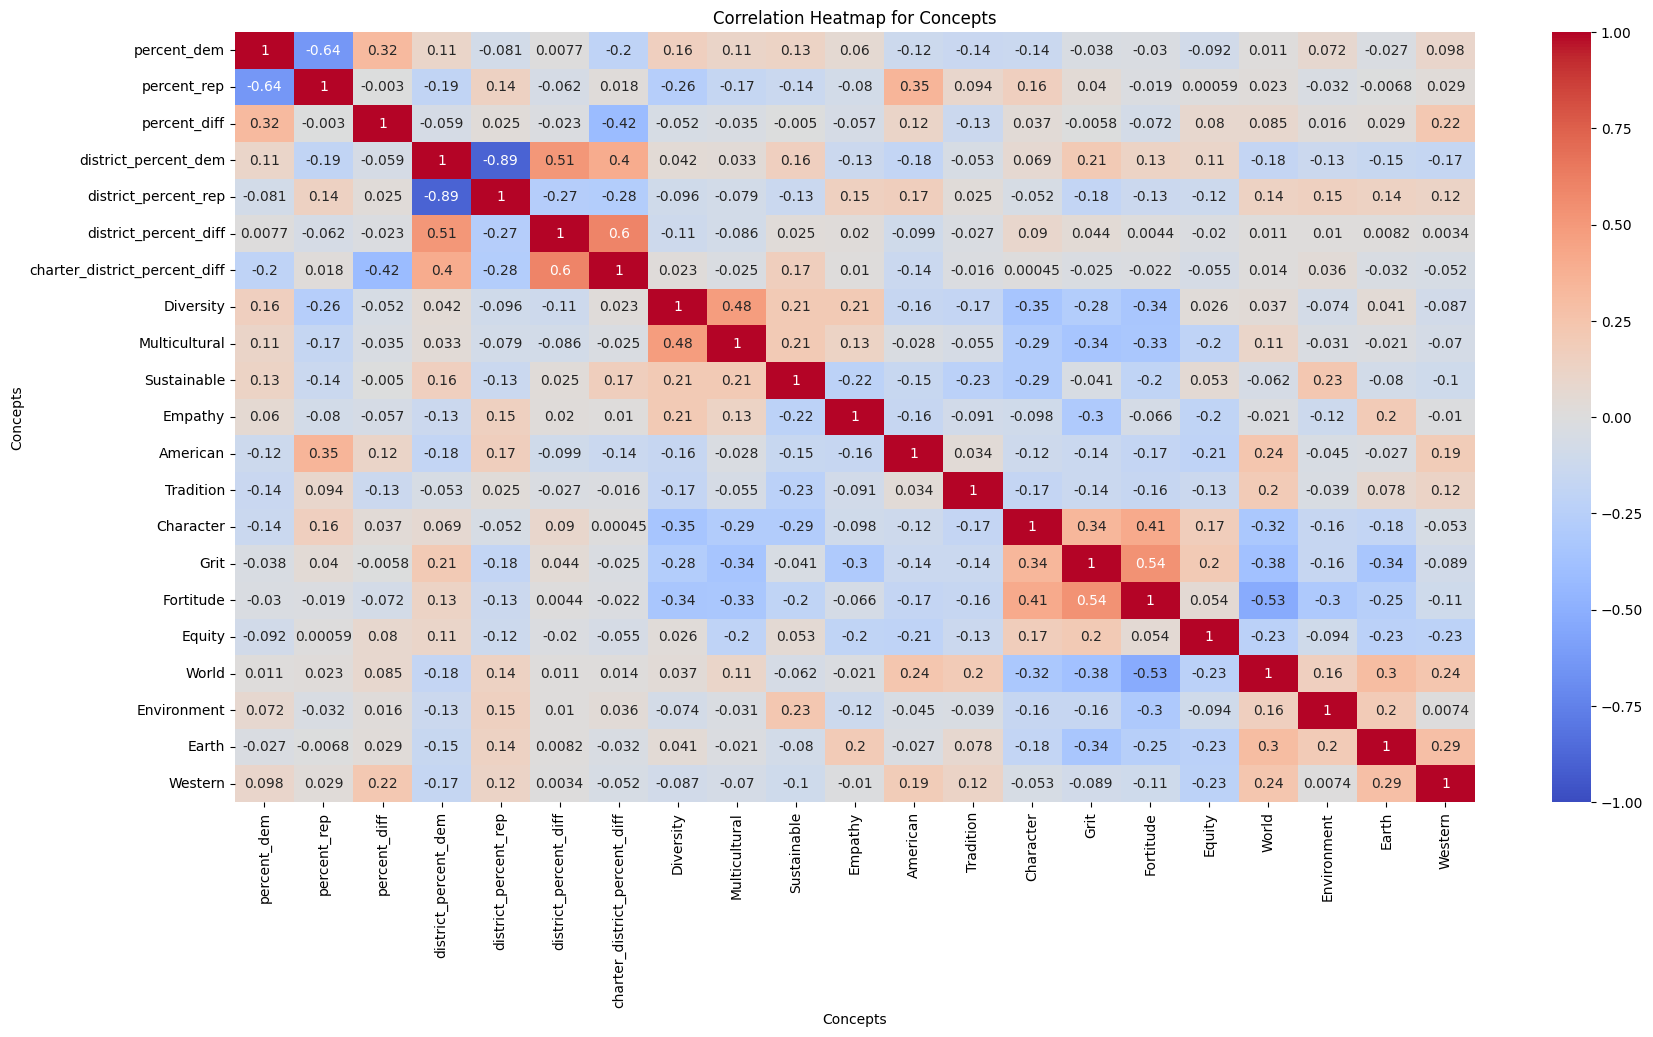

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizing the correlation using a heatmap
plt.figure(figsize=(20, 10))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, vmin=-1, vmax=1)

# Optional: Add labels and a title
plt.title("Correlation Heatmap for Concepts")
plt.xlabel("Concepts")
plt.ylabel("Concepts")

plt.show()

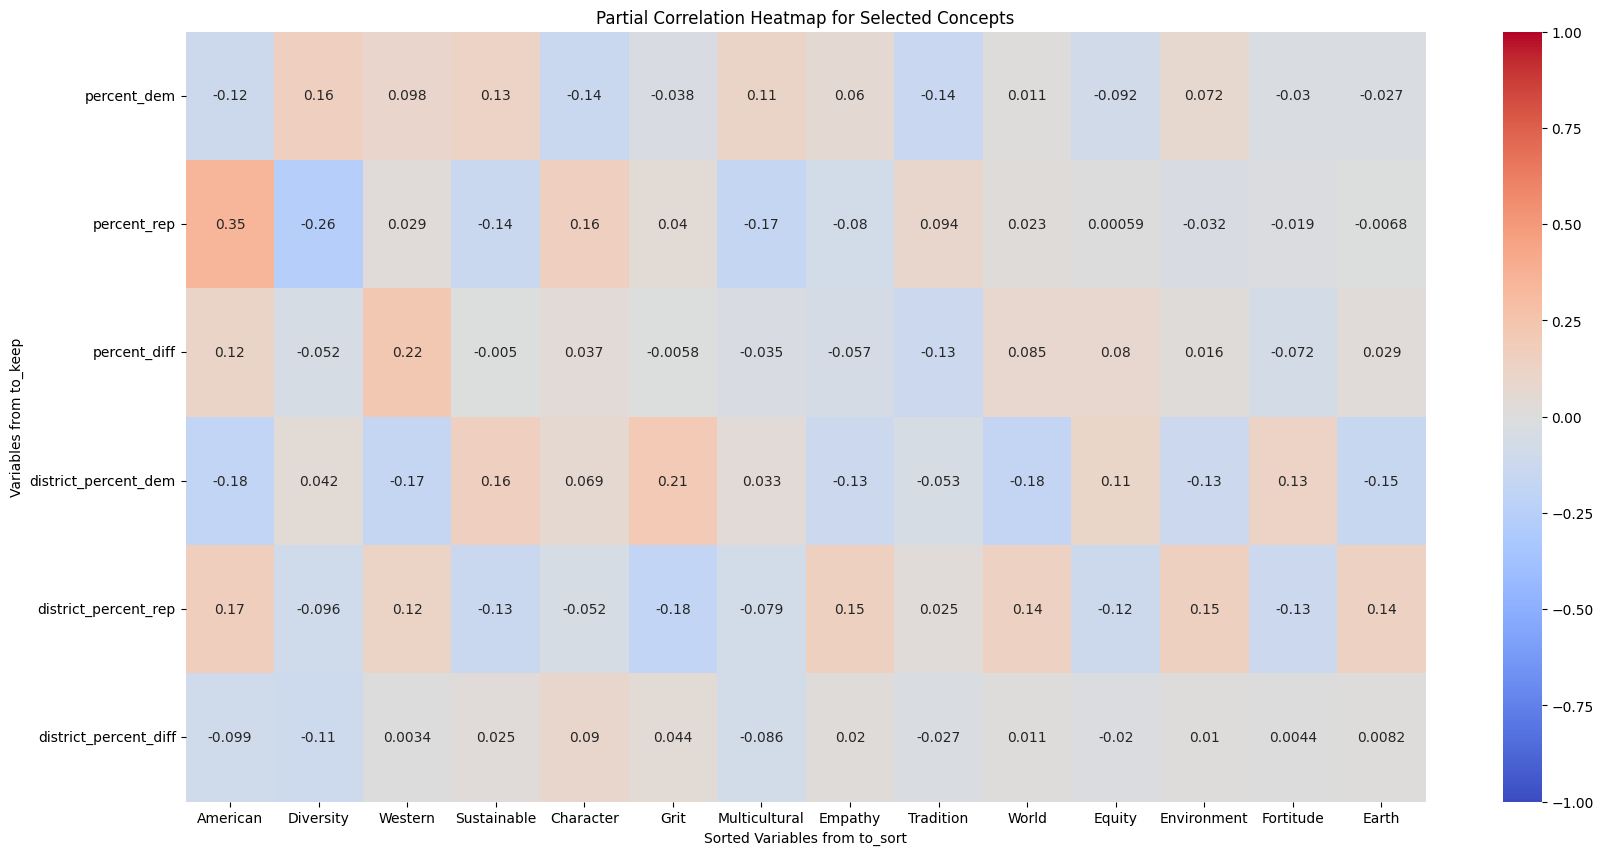

In [67]:
to_sort = ['Diversity','Multicultural','Sustainable', 'Empathy',  'American', 'Tradition', 'Character', 'Grit', 'Fortitude','Equity', 'World', 'Environment','Earth', 'Western',]
to_keep = ['percent_dem', 'percent_rep', 'percent_diff',
       'district_percent_dem', 'district_percent_rep', 'district_percent_diff','charter_district_percent_diff']

# Compute correlations between the columns in to_keep and to_sort
partial_correlations = complete_experiment[to_keep].apply(lambda col: complete_experiment[to_sort].corrwith(col)).T

# Calculate the average absolute correlations for the columns in to_sort
avg_abs_correlations = partial_correlations.abs().mean().sort_values(ascending=False)

# Sort the columns based on average absolute correlations
sorted_columns = avg_abs_correlations.index.tolist()

# Reorganize the correlation matrix based on the sorted columns
sorted_partial_correlations = partial_correlations[sorted_columns]

# Visualizing the correlations using a heatmap
plt.figure(figsize=(20, 10))

# Create a heatmap for the rearranged partial correlation matrix
sns.heatmap(sorted_partial_correlations, cmap="coolwarm", annot=True, vmin=-1, vmax=1)

# Optional: Add labels and a title
plt.title("Partial Correlation Heatmap for Selected Concepts")
plt.xlabel("Sorted Variables from to_sort")
plt.ylabel("Variables from to_keep")

plt.show()


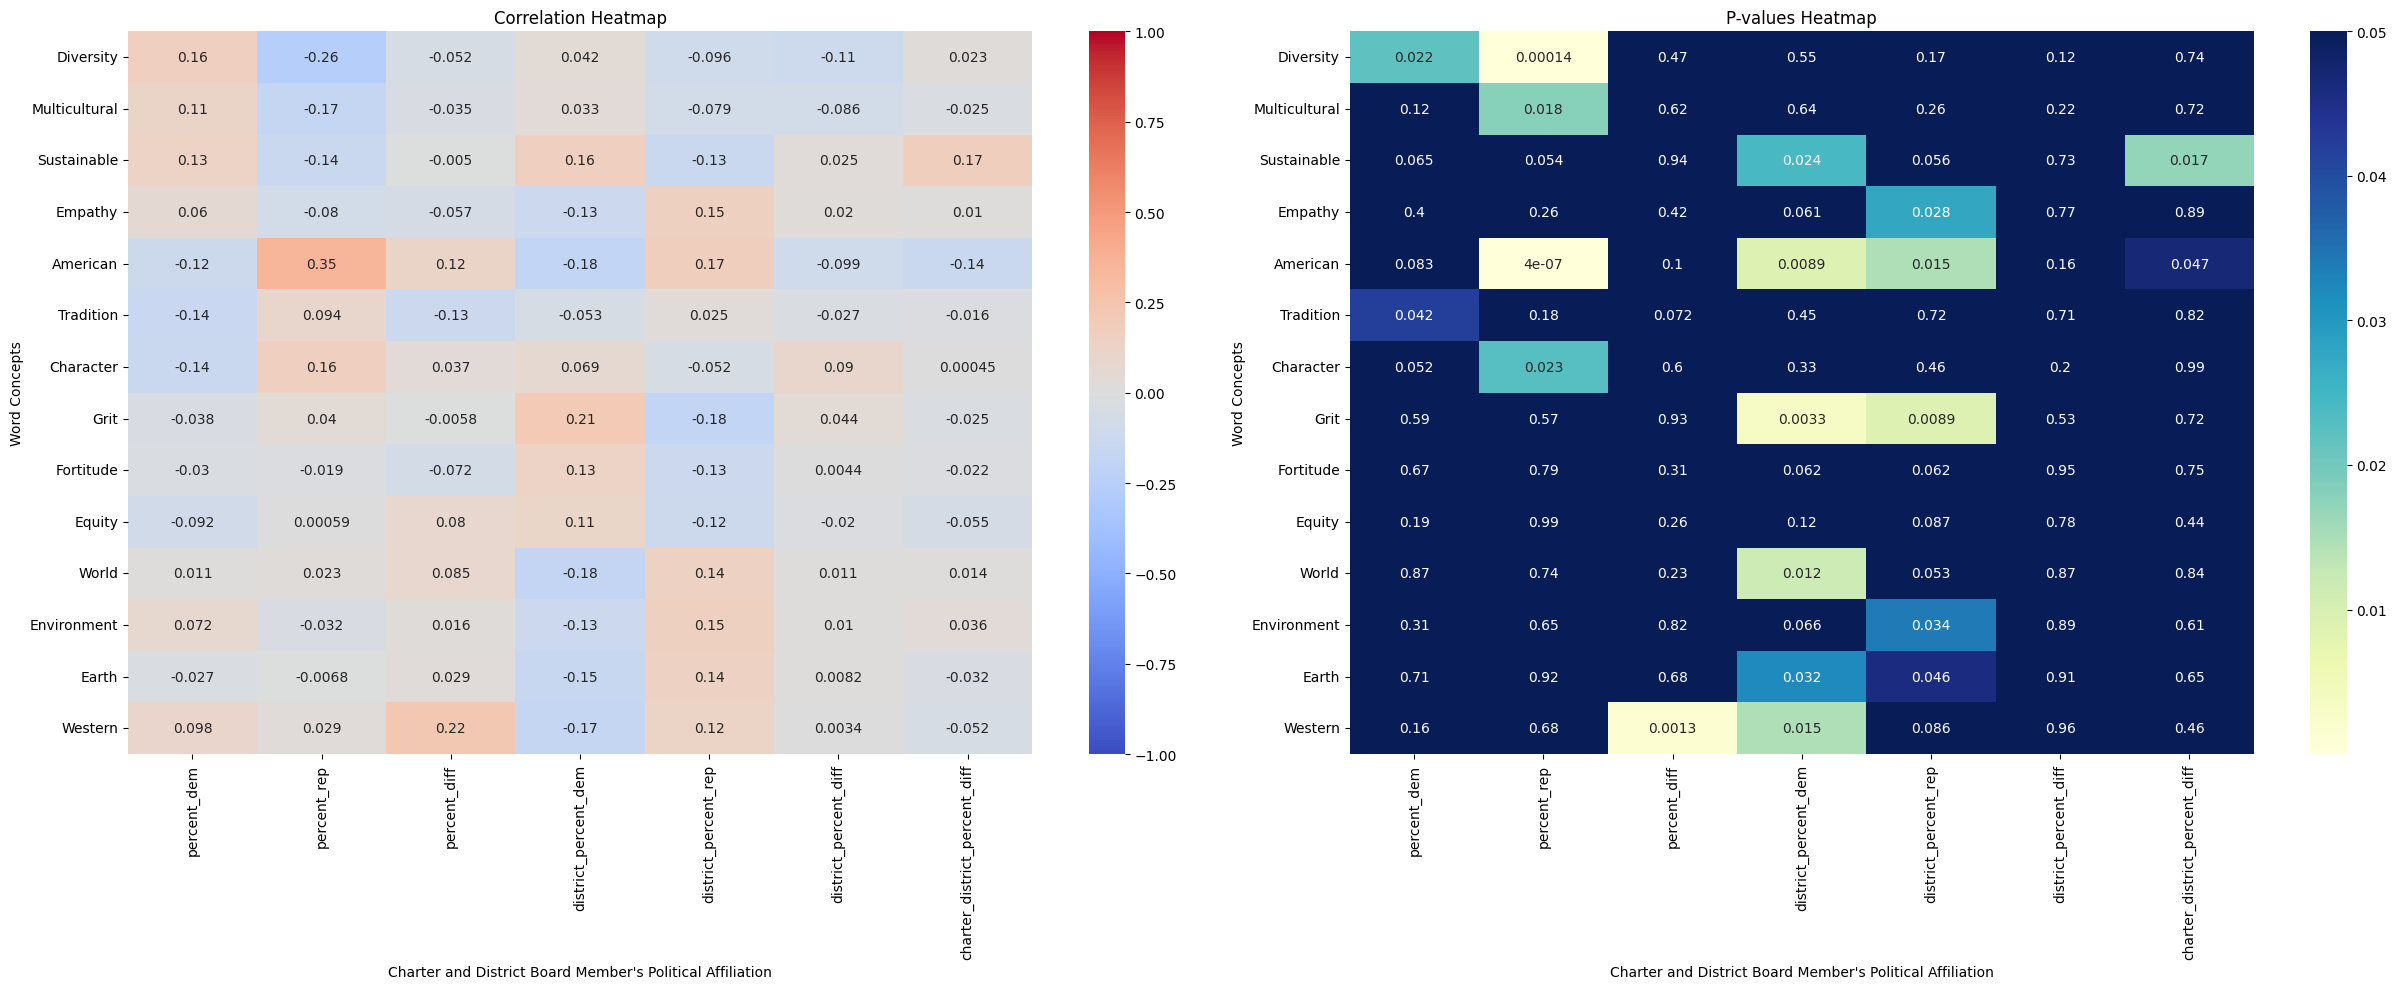

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define the columns
to_sort = ['Diversity', 'Multicultural', 'Sustainable', 'Empathy', 'American', 'Tradition', 'Character', 'Grit', 'Fortitude', 'Equity', 'World', 'Environment', 'Earth', 'Western']
to_keep = ['percent_dem', 'percent_rep', 'percent_diff',
           'district_percent_dem', 'district_percent_rep', 'district_percent_diff','charter_district_percent_diff']

# Compute correlation and p-value
def compute_corr_and_pvalue(x, y):
    corr, pvalue = pearsonr(x, y)
    return corr, pvalue

# Create empty DataFrames to store correlation values and p-values
correlation_values = pd.DataFrame(index=to_sort, columns=to_keep)
pvalues = pd.DataFrame(index=to_sort, columns=to_keep)

# Assuming 'complete_experiment' DataFrame is already defined and loaded with data
for keep in to_keep:
    for sort in to_sort:
        # Assuming the 'sort' columns and 'keep' columns are clean and have no NaN values
        # Otherwise, you should handle NaNs before computing correlations
        corr, pvalue = compute_corr_and_pvalue(complete_experiment[keep], complete_experiment[sort])
        correlation_values.at[sort, keep] = corr
        pvalues.at[sort, keep] = pvalue

# Define the order of rows explicitly as per your requirement
row_order = ['Diversity', 'Multicultural', 'Sustainable', 'Empathy', 'American', 'Tradition', 'Character', 'Grit', 'Fortitude', 'Equity', 'World', 'Environment', 'Earth', 'Western']

# Use this row order to reorder the DataFrames
sorted_correlation_values = correlation_values.loc[row_order]
sorted_pvalues = pvalues.loc[row_order]

sorted_correlation_values = sorted_correlation_values.apply(pd.to_numeric, errors='coerce')
sorted_pvalues = sorted_pvalues.apply(pd.to_numeric, errors='coerce')

# Visualizing the correlations and p-values using heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Heatmap for correlations
sns.heatmap(sorted_correlation_values, cmap="coolwarm", annot=True, vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Correlation Heatmap")
ax1.set_ylabel("Word Concepts")
ax1.set_xlabel("Charter and District Board Member's Political Affiliation")

# Heatmap for p-values
sns.heatmap(sorted_pvalues, cmap="YlGnBu", annot=True, vmax=0.05, ax=ax2)
ax2.set_title("P-values Heatmap")
ax2.set_ylabel("Word Concepts")
ax2.set_xlabel("Charter and District Board Member's Political Affiliation") 

plt.tight_layout()
plt.show()


In [72]:
sorted_correlation_values

,percent_dem,percent_rep,percent_diff,district_percent_dem,district_percent_rep,district_percent_diff,charter_district_percent_diff
Diversity,0.160777,-0.263797,-0.051516,0.041824,-0.096099,-0.110457,0.023403
Multicultural,0.109376,-0.165682,-0.034709,0.032896,-0.079175,-0.085558,-0.024996
Sustainable,0.129819,-0.135209,-0.004983,0.158016,-0.134406,0.024634,0.167256
Empathy,0.059864,-0.079601,-0.057468,-0.131963,0.154717,0.020276,0.010006
American,-0.121852,0.346790,0.115676,-0.183210,0.170926,-0.098753,-0.139784
Tradition,-0.142749,0.093542,-0.126383,-0.053256,0.025215,-0.026694,-0.016057
Character,-0.136783,0.159771,0.036956,0.068771,-0.052398,0.090370,0.000447
Grit,-0.038179,0.039620,-0.005790,0.205507,-0.183286,0.044459,-0.024912
Fortitude,-0.029952,-0.018948,-0.072102,0.131340,-0.131284,0.004407,-0.022485
Equity,-0.091867,0.000591,0.079929,0.109346,-0.120246,-0.020065,-0.054755


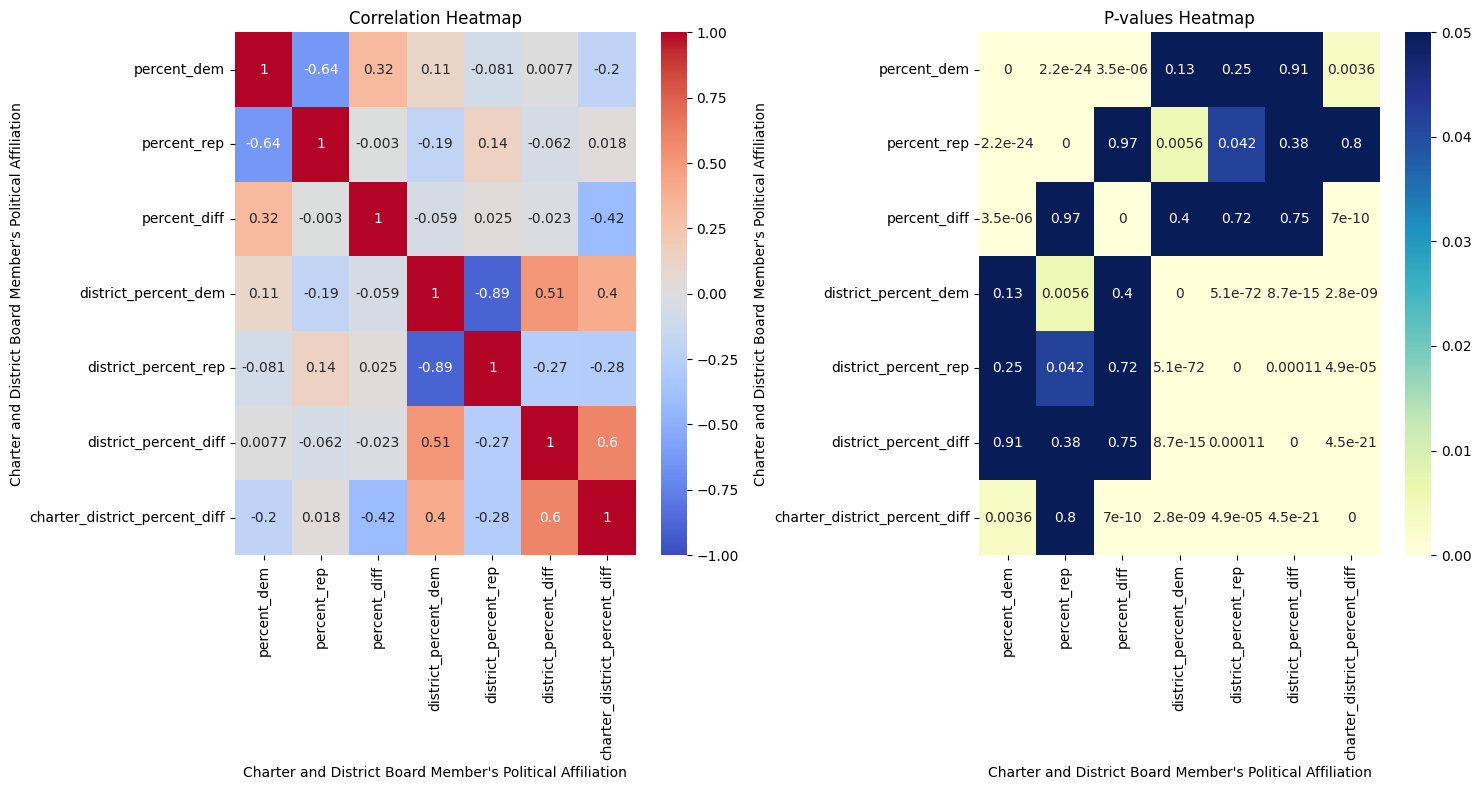

In [73]:
# Define the columns to keep
to_keep = ['percent_dem', 'percent_rep', 'percent_diff',
       'district_percent_dem', 'district_percent_rep', 'district_percent_diff','charter_district_percent_diff']
# Compute correlation and p-value
def compute_corr_and_pvalue(x, y):
    corr, pvalue = pearsonr(x, y)
    return corr, pvalue

# Create empty DataFrames to store correlation values and p-values
correlation_values = pd.DataFrame(index=to_keep, columns=to_keep)
pvalues = pd.DataFrame(index=to_keep, columns=to_keep)

# Populate the DataFrames
for i in to_keep:
    for j in to_keep:
        corr, pvalue = compute_corr_and_pvalue(complete_experiment[i], complete_experiment[j])
        correlation_values.at[i, j] = corr
        pvalues.at[i, j] = pvalue

# Visualizing the correlations and p-values using heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Heatmap for correlations
sns.heatmap(correlation_values.astype(float), cmap="coolwarm", annot=True, vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Correlation Heatmap")

label = "Charter and District Board Member's Political Affiliation"

ax1.set_ylabel(label)
ax1.set_xlabel(label)

# Heatmap for p-values
sns.heatmap(pvalues.astype(float), cmap="YlGnBu", annot=True, vmax=0.05, ax=ax2)
ax2.set_title("P-values Heatmap")
ax2.set_ylabel(label)
ax2.set_xlabel(label)

plt.tight_layout()
plt.show()